# 1.0 An end-to-end classification problem (Testing)



## 1.1 Dataset description

The datasets accessed were from **bank-full.csv** ordered by date (from May 2008 to November 2010) with all examples and 17 entries, sorted by date (older version of this dataset with fewer entries).

The input variables are related the data of **bank customers**, related with the **last contact** of the current campaign and attributes related to **campaign previus**.

The classification goal is to predict if the client will **subscribe** (yes/no) a **term deposit** (variable y).

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training (done)
5. Test

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1hlrTKNJOg6Svs7V6ihiypsy21UVBTJWv"></center>


## 1.2 Install, load libraries

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 24.9 MB/s 
     |████████████████████████████████| 181 kB 57.3 MB/s 
     |████████████████████████████████| 144 kB 57.7 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=57cabcf1a28157b90ac0323254bc7e2e872d219e49eb0c91e64ab81f093f621f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Test evaluation

### 1.3.1 Definition of the base classes

This is necessary in order to ```joblib.load()```see the previous definitions used in the Train Pipeline.

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:

            # minimize the cardinality of native_country feature
            # check cardinality using df.native_country.unique()
            df.loc[df['native_country'] != 'United-States','native_country'] = 'non_usa'

            # replace ? with Unknown
            edit_cols = ['native_country', 'occupation', 'workclass']
            for col in edit_cols:
                df.loc[df[col] == '?', col] = 'unknown'

            # decrease the cardinality of education feature
            hs_grad = ['HS-grad', '11th', '10th', '9th', '12th']
            elementary = ['1st-4th', '5th-6th', '7th-8th']
            # replace
            df['education'].replace(to_replace=hs_grad,value='HS-grad',inplace=True)
            df['education'].replace(to_replace=elementary,value='elementary_school',inplace=True)

            # adjust marital_status feature
            married = ['Married-spouse-absent','Married-civ-spouse','Married-AF-spouse']
            separated = ['Separated', 'Divorced']

            # replace
            df['marital_status'].replace(to_replace=married, value='Married', inplace=True)
            df['marital_status'].replace(to_replace=separated, value='Separated', inplace=True)

            # adjust workclass feature
            self_employed = ['Self-emp-not-inc', 'Self-emp-inc']
            govt_employees = ['Local-gov', 'State-gov', 'Federal-gov']

            # replace elements in list.
            df['workclass'].replace(to_replace=self_employed,value='Self_employed',inplace=True)
            df['workclass'].replace(to_replace=govt_employees,value='Govt_employees',inplace=True)

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### 1.3.2 Evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "decision_tree/test.csv:latest"

# name of the model artifact
artifact_model_name = "decision_tree/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "decision_tree/target_encoder:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="decision_tree",job_type="test")

wandb: Currently logged in as: francisval (use `wandb login --relogin` to force relogin)


In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("high_income")

20-04-2022 01:42:22 Downloading and reading test artifact
20-04-2022 01:42:23 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,60,State-gov,234854,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,40,United-States
1,19,Private,82210,HS-grad,9,Never-married,Sales,Not-in-family,White,Male,0,0,50,United-States
2,49,Private,204629,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
3,27,Private,201872,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States
4,34,Private,230246,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,?


In [ ]:
# Take a look at the target variable
y_test.head()

0      >50K
1     <=50K
2      >50K
3     <=50K
4     <=50K
Name: high_income, dtype: object

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

20-04-2022 01:42:46 Extracting the encoding of the target variable


In [ ]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

20-04-2022 01:43:02 Classes [0, 1]: [' <=50K' ' >50K']


In [ ]:
# target variable after the encoding
y_test

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

20-04-2022 01:43:14 Downloading and load the exported model


In [ ]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

20-04-2022 01:43:22 Infering
20-04-2022 01:43:22 Test Evaluation metrics
20-04-2022 01:43:22 Test Accuracy: 0.8018848596599057
20-04-2022 01:43:22 Test Precision: 0.5884094754653131
20-04-2022 01:43:22 Test Recall: 0.5914115646258503
20-04-2022 01:43:22 Test F1: 0.5899067005937236


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7410
           1       0.59      0.59      0.59      2352

    accuracy                           0.80      9762
   macro avg       0.73      0.73      0.73      9762
weighted avg       0.80      0.80      0.80      9762



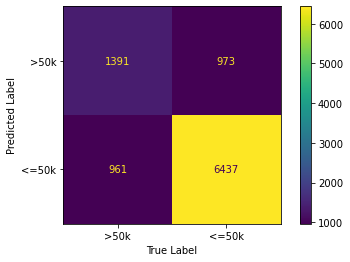

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

20-04-2022 01:43:38 Uploading figures


In [ ]:
run.finish()

Acc,0.80188
F1,0.58991
Precision,0.58841
Recall,0.59141
